# Feature Engineering Toolkit

- This notebook builds reusable time-series features for retail forecasting.

Cell 1 — Imports + Load Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load from baseline module data folder
train = pd.read_csv("../baseline_prophet_forecast/data/train.csv")
features = pd.read_csv("../baseline_prophet_forecast/data/features.csv")
stores = pd.read_csv("../baseline_prophet_forecast/data/stores.csv")

df = (
    train
    .merge(features, on=["Store", "Date", "IsHoliday"])
    .merge(stores, on="Store")
)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Store", "Dept", "Date"])
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


Cell 2 — Select a Store–Dept Series (for demonstration)

In [18]:
store = 1
dept = 1

ts = df[(df["Store"] == store) & (df["Dept"] == dept)].copy()
ts = ts.set_index("Date").sort_index()

# Weekly alignment
#ts = ts.asfreq("W")
ts[["Weekly_Sales", "IsHoliday"]].head()


,Weekly_Sales,IsHoliday
Date,,
2010-02-05,24924.50,False
2010-02-12,46039.49,True
2010-02-19,41595.55,False
2010-02-26,19403.54,False
2010-03-05,21827.90,False


Cell 3 — Define the Feature Function (Reusable)

This is the core deliverable. It is designed to avoid leakage by shifting before rolling.

In [19]:
def make_features(d: pd.DataFrame, target: str = "Weekly_Sales") -> pd.DataFrame:
    """
    Feature engineering for weekly retail demand forecasting.

    Expects:
      - index is datetime at weekly frequency
      - columns include target (e.g., Weekly_Sales) and IsHoliday

    Returns:
      - same frame with engineered features added
    """
    x = d.copy()

    # Time features
    x["weekofyear"] = x.index.isocalendar().week.astype(int)
    x["month"] = x.index.month
    x["year"] = x.index.year

    # Lag features (weeks)
    for lag in [1, 2, 4, 8, 13, 26, 52]:
        x[f"lag_{lag}"] = x[target].shift(lag)

    # Rolling window features (use shift(1) to avoid using current week)
    for win in [4, 8, 12, 24]:
        base = x[target].shift(1)
        x[f"roll_mean_{win}"] = base.rolling(win).mean()
        x[f"roll_std_{win}"] = base.rolling(win).std()
        x[f"roll_min_{win}"] = base.rolling(win).min()
        x[f"roll_max_{win}"] = base.rolling(win).max()

    # Momentum / change features
    x["diff_1"] = x[target].diff(1)
    x["pct_change_1"] = x[target].pct_change(1)

    # Holiday proximity window (captures pre/post holiday effects)
    if "IsHoliday" in x.columns:
        x["holiday_window_3"] = x["IsHoliday"].rolling(3, center=True).max().fillna(0).astype(int)
    else:
        x["holiday_window_3"] = 0

    # Year-over-year
    x["yoy_change"] = (x[target] - x[target].shift(52)) / x[target].shift(52)

    # Fourier terms (weekly seasonality; boosting models benefit)
    for k in [1, 2, 3]:
        x[f"fourier_sin_{k}"] = np.sin(2 * np.pi * x["weekofyear"] * k / 52)
        x[f"fourier_cos_{k}"] = np.cos(2 * np.pi * x["weekofyear"] * k / 52)

    return x


Cell 4 — Apply Features + Create Model-Ready Table

In [20]:
feat = make_features(ts, target="Weekly_Sales")
feat = feat.dropna()

target_col = "Weekly_Sales"
feature_cols = [c for c in feat.columns if c != target_col]

feat[feature_cols].head()


,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,diff_1,pct_change_1,holiday_window_3,yoy_change,fourier_sin_1,fourier_cos_1,fourier_sin_2,fourier_cos_2,fourier_sin_3,fourier_cos_3
Date,,,,,,,,,,,,,,,,,,,,,
2011-11-11,1,1,False,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,...,-21196.52,-0.531427,0,-0.043983,-0.748511,0.663123,-0.992709,-0.120537,-0.568065,-0.822984
2011-11-18,1,1,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,...,361.12,0.019322,1,-0.025683,-0.663123,0.748511,-0.992709,0.120537,-0.822984,-0.568065
2011-11-25,1,1,True,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,...,1860.59,0.097665,1,0.111101,-0.568065,0.822984,-0.935016,0.354605,-0.970942,-0.239316
2011-12-02,1,1,False,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,...,4382.24,0.209564,1,0.123278,-0.464723,0.885456,-0.822984,0.568065,-0.992709,0.120537
2011-12-09,1,1,False,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,...,8012.43,0.316778,0,0.057410,-0.354605,0.935016,-0.663123,0.748511,-0.885456,0.464723


Save a “ready” dataset (useful for the LightGBM module):

In [21]:
feat.to_csv("features_store1_dept1.csv", index=True)

Cell 5 — Quick Diagnostics: Correlation Heatmap (Top Features)

Correlation across all features can be large; keep it focused.

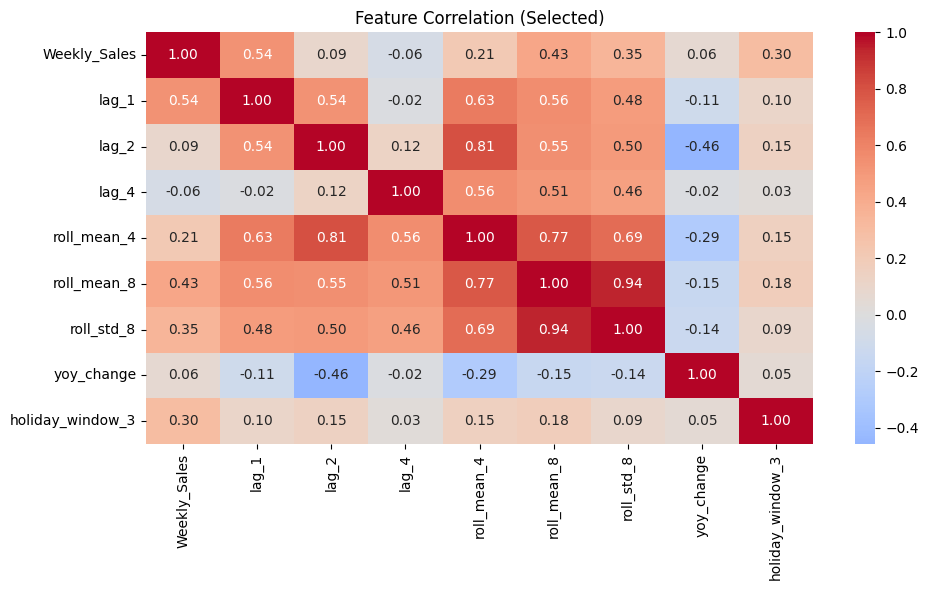

In [22]:
import os
os.makedirs("images", exist_ok=True)

corr_cols = ["Weekly_Sales", "lag_1", "lag_2", "lag_4", "roll_mean_4", "roll_mean_8", "roll_std_8", "yoy_change", "holiday_window_3"]
corr_cols = [c for c in corr_cols if c in feat.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(feat[corr_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation (Selected)")
plt.tight_layout()
plt.savefig("images/feature_correlation_selected.png")
plt.show()

## No Data Leakage Checklist

When creating features for time series forecasting, it's critical to avoid **data leakage** - using future information to predict the past. Here's how this feature function prevents leakage:

✅ **Lag features use `.shift(lag)`**
- `lag_1` shifts the target back by 1 week, so we're only using past values
- Never uses the current week's sales to predict itself

✅ **Rolling windows use `.shift(1).rolling(win)`**
- First shift by 1 week, then calculate rolling statistics
- Ensures rolling mean/std doesn't include the current observation

✅ **No forward-looking columns**
- All features are derived from past data only
- Holiday window uses `center=True` with caution (captures surrounding weeks)

✅ **Reusable for training and inference**
- Same feature logic works for historical model training
- Can be applied to new data for predictions without modification
- Feature store concept: consistent features across environments

This ensures the model learns from legitimate patterns, not data it wouldn't have access to in production.